<div style="background:#FFFFAA">
<img src="./logo.jpg", width=150, ALIGN="left", border=20>
<h1>L2RPN Starting Kit </h1> 

<br>This code was tested with <br>
Python 3.6.6 |Anaconda custom (64-bit)| (default, Nov 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p> 
     <br>
The goal of this challenge is to use Reinforcement Learning in Power Grid management by designing RL agents to automate the control of the power grid. The dataset used in this challenge is from <a href="https://github.com/MarvinLer/pypownet">pypownet</a>, made by Marvin Lerousseau, it is a simulator that is able to emulate a power grid of any size and electrical properties subject to a set of temporal injections for discretized time-steps.

References and credits: <br>
Founder of pypownet was Marvin Lerousseau. The competition protocol was designed by Isabelle Guyon. Our mentors are Balthazar Donon and Antoine Marot. Pypownet, 2017. https://github.com/MarvinLer/pypownet. The baseline methods were inspired by work performed by Kimang Khun.
 <br> 
</div>

In [19]:
model_dir = 'example_submission/'
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
input_dir = 'public_data/'
output_dir = 'output/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide data with the starting kit.
    <br>
</div>

## Electrical grid
<div >
<img src="./ExampleGrid.JPG", width=750, ALIGN="left", border=20>
    <br>
    <br>
(courtesy of Marvin Lerousseau)
</div>

During the challenge, a grid of 14 substations is given. 20 lines connected the nodes of the network.

For the following example, we take the case where there are 11 loads and 5 prods and particularly the hard level. Furthermore, the information shown are only those of January.

In [20]:
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
!ls $data_dir*

chronics  configuration.yaml  reference_grid.m


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" to explore the data.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

loads_p_file = '_N_loads_p.csv'
prods_p_file = '_N_prods_p.csv'
datetimes_file = '_N_datetimes.csv'
maintenance_file = 'maintenance.csv'
hazards_file = 'hazards.csv'
imaps_file = '_N_imaps.csv'
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 
i = 0 # chronics id

path = data_dir+'/chronics/'+str(i)+'/'
df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')

## Loads

The following figure shows the active power of consumptions which represents the amount of demand of active power. This information appears in the \_N\_loads\_p.csv. Note that the power needed is cyclic during the day. In our particular case, the load 3_C151.15 is the one which needs power the most power. The loads for the other levels are pretty similar with a load needing much more power than the others.

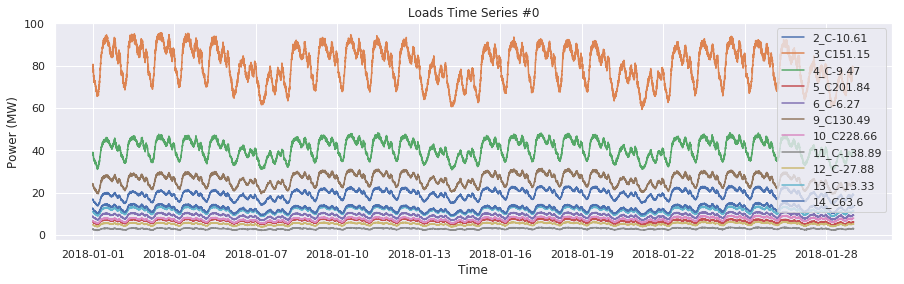

In [22]:
plt.figure(figsize=[15,4])
plt.title('Loads Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_loads_p[str(0)])
plt.legend(list(df_loads_p[str(0)]))
plt.show()

## Production

The active power of the productions is shown below. In the easy mode, each one of them is stable contrary to the medium and hard modes where the productions are much more heterogeneous.

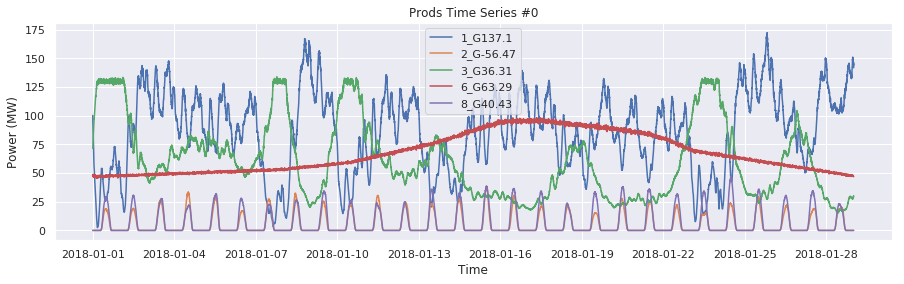

In [23]:
plt.figure(figsize=[15,4])
plt.title('Prods Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_prods_p[str(0)])
plt.legend(list(df_prods_p[str(0)]))
plt.show()

## Maintenance

Maintenance exist only for the hard mode. When a maintenance happens for a production, the voltage magnitudes of the associated production is set to 0 in \_N\_prods\_v.csv for a number of timesteps. Here, two maintenances happen in January.

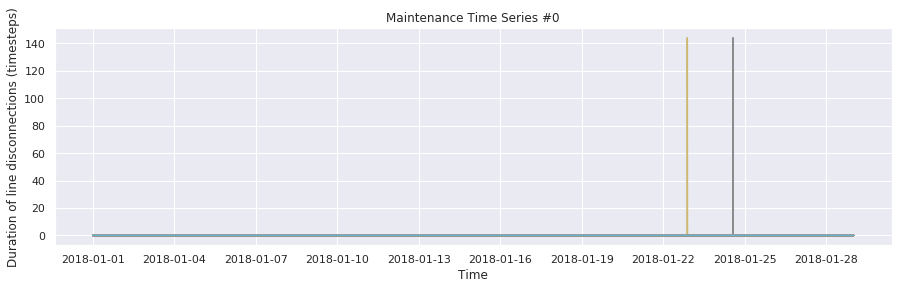

In [24]:
plt.figure(figsize=[15,4])
plt.title('Maintenance Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Duration of line disconnections (timesteps)')
plt.plot(df_maintenance[str(0)])
plt.show()

## Hazard

Again, hazards only happen with the hard mode. They represent external events that break lines from time to time, be it natural hazards or ones related to the network itself.

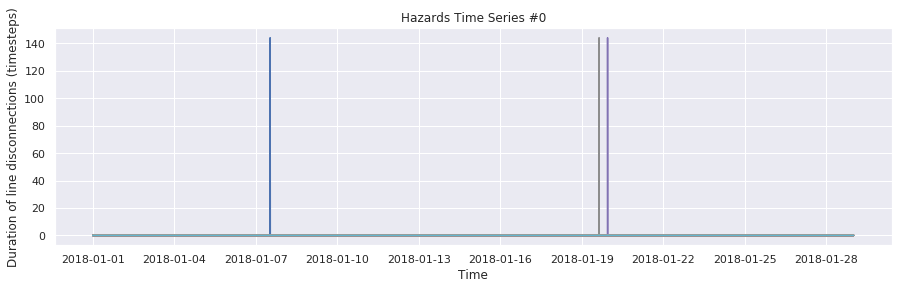

In [25]:
plt.figure(figsize=[15,4])
plt.title('Hazards Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Duration of line disconnections (timesteps)')
plt.plot(df_hazards[str(0)])
plt.show()

<div style="background:#FFFFAA">
<h1>Step 2: Building an Agent</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with pypownet</h2>
    <p>
We reload the data with the environment class of pypownet
   <br>
    
To win, flows in a line have to stay under a threshold. Above this threshold, the line will overheat and after a certain amount of overheating, the line will break. Thermal limits are already defined in pypownet.
</div>

In [26]:
import os
import pypownet.environment
import pypownet.runner
data_dir = 'public_data'  
environment = pypownet.environment.RunEnv(parameters_folder=os.path.abspath(data_dir),
                                              game_level="hard",
                                              chronic_looping_mode='natural', start_id=0,
                                              game_over_mode="soft")

<div style="background:#FFFFAA">
    <h2>Building an agent</h2>
    <p>
We provide examples of agent (for reinforcement learning) in the `starting-kit/example_submission` directory. It is a quite stupid agent: it does nothing. Replace it with your own agent.
    </div>

## Do nothing agent

The agent does not take any actions.

In [27]:
import pypownet.agent
import pypownet.environment


class DoNothingAgent(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)

    def act(self, observation):
        """ Produces an action given an observation of the environment. Takes as argument an observation of the current
        power grid, and returns the chosen action."""
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)

        action_space = self.environment.action_space

        # Implement your policy here
        # Example of the do-nothing policy that produces no action (i.e. an action that does nothing) each time
        do_nothing_action = action_space.get_do_nothing_action()

        # Sanity check: verify the good overall structure of the returned action; raises exceptions if not valid
        assert action_space.verify_action_shape(do_nothing_action)
        return do_nothing_action


In [28]:
from example_submission import baseline_agents
# Uncomment the next line to display the code of the DoNothing Agent
#??baseline_agents.DoNothingAgent

## RandomLineSwitch agent
The agent randomly switches the status of one random power line per timestep (if the random line is previously online, switch it off, otherwise switch it on

In [29]:
from example_submission import baseline_agents
# Uncomment the next line to display the code of the RandomLineSwitch Agent
#??baseline_agents

## RandomNodeSplitting agent
The agent selects a random switch configuration such that switched elements of the selected substations change the node within the substation on which they are directly wired.

In [30]:
from example_submission import baseline_agents
# Uncomment the next line to display the code of the RandomNodeSplitting Agent
#??baseline_agents.RandomNodeSplitting

<div style="background:#FFFFAA">
an instance of the agent (run the constructor) and attempt to reload a previously saved version from `starting_kit/example_submission/`:
    
</div>

## Scoring the results of an agent

<div style="background:#FFFFAA">
    <br>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    <br>
The aim of a reinforcement learning problem is to maximize the reward function.

When running the agent, two values are given back : the first one is the reward of the last timestep and the second one is the cumulative reward for all the iterations of the run of the agent. The reward indicates if the game is going towards a game over or not.

Specifically, our reward function is composed of 5 subrewards. They describe the proportion of isolated productions, loads, the cost of an action, an indication of the amount of changes between the current grid and the initial grid and lastly information on the lines capacity usage. 
    </div>

In [31]:
from scoring_program import libscores
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: reward


### Run the Do nothing agent

In [32]:
import time
start = time.time()
end = time.time()
print(end-start)

1.5974044799804688e-05


In [33]:
import logging
import sys
import os
start = time.time()
NUMBER_ITERATIONS = 50 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.DoNothingAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

cumulative rewards : -11.269334237132293
0.8339841365814209


In [34]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -11.27


In [43]:
import logging
import sys
import os
start = time.time()
NUMBER_ITERATIONS = 50 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.CustomAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler,verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

INFO        step 1/50 - reward: 3.90; cumulative reward: 3.90


reward: [ -0.00, -0.00, 4.00, -0.00, -0.10 ] = 3.8954824097251253
Action chosen:  turning ON lines 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
turning OFF lines  ; expected reward 3.8955


ValueError: max() arg is an empty sequence

In [44]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 1, cumulative rewards : 3.9


### Run the RandomLineSwitch agent

In [ ]:
import logging
import sys
start = time.time()
NUMBER_ITERATIONS = 50

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.RandomLineSwitch(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

In [ ]:
#get the score with the scoring_function
scoring_function(output_dir)

### Run the RandomNodeSplitting agent

In [ ]:
import logging
import sys
start = time.time()
NUMBER_ITERATIONS = 50

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.RandomNodeSplitting(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

In [ ]:
#get the score with the scoring_function
scoring_function(output_dir)

<div style="background:#FFFFAA">
    <b> Save the best agent </b> it should be a class Submission and save in "example_submission/submission.py".  Uncomment the line <i>%%writefile example_submission/submission.py to save the agent. </i>
</div>

In [ ]:
#%%writefile example_submission/submission.py
import pypownet.agent
import pypownet.environment

class Submission(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)

    def act(self, observation):
        """ Produces an action given an observation of the environment. Takes as argument an observation of the current
        power grid, and returns the chosen action."""
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)

        action_space = self.environment.action_space

        # Implement your policy here
        # Example of the do-nothing policy that produces no action (i.e. an action that does nothing) each time
        do_nothing_action = action_space.get_do_nothing_action()

        # Sanity check: verify the good overall structure of the returned action; raises exceptions if not valid
        assert action_space.verify_action_shape(do_nothing_action)
        return do_nothing_action

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>submission.py</code> in the <code>starting_kit/example_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!python $problem_dir/ingestion.py $input_dir $input_dir/res $problem_dir $model_dir

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [ ]:
scoring_output_dir = 'output'
!python $score_dir/evaluate.py $input_dir $scoring_output_dir

<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = 'sample_code_submission_' + the_date + '.zip' 
zipdir(sample_code_submission, model_dir) 
print("Submit one of these files:\n" + sample_code_submission + "\n")

In [ ]:
import logging
import sys
import time
start = time.time()
NUMBER_ITERATIONS = 50 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.GreedySearch(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

In [ ]:
import logging
import sys
import time
start = time.time()
NUMBER_ITERATIONS = 50 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.TreeSearchLineServiceStatus(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)